#Data Driven Problem Solving Final Project Part II

#Mapping Amazon Food Reviews to Stars
#Writers: Irene Won Choi & Khushant Khurana
---
For this project, a neural network is created using Pytorch to map the amazon reviews on food items to the corresponding stars. Models like such are extremely important in determining a quantitative analysis for the specified food. While the review can help the restaurant by giving detials, quantitative analysis like stars can be used for marketting because of their anonymous nature. The datasetfor this project is derived from Kaggle: https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial/input. The dataset contains about 568454 reviews and the categories for given stars are 1, 2, 3, 4, and 5. Treating it as a classification problem, variation of hyper-parameters is used to tune the model and the network is also evolved into a deep network by adding more layers and the final accuracies are compared.


#Downloading required libraries: <a name="Download"></a></font>



In [1]:
!pip install torch
!pip install pandas
!pip install tqdm

#Importing libraries!!

---



In [2]:
# Importing general libraries!
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Importing torch and its functionalities for text processing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

#Training the network on GPU for faster processing

---



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Importing dataset

---



In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Only 10000 rows of the dataset are incorporated in the training of the neural network to make it less computationally expensive.
data = pd.read_csv("/content/drive/MyDrive/Reviews.csv", header=0).head(10000)

# Displaying bits of data to get a sense of it.
display(data.head(5))
x_data = np.array(data.loc[:, "Text"])
y_data = np.array(data.loc[:, "Score"])
y_data = y_data - 1 # Subtracting 1 because labels are arranged from 1-5.

Mounted at /content/drive


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#Checking the distribution of the data with respect to the labels.

---



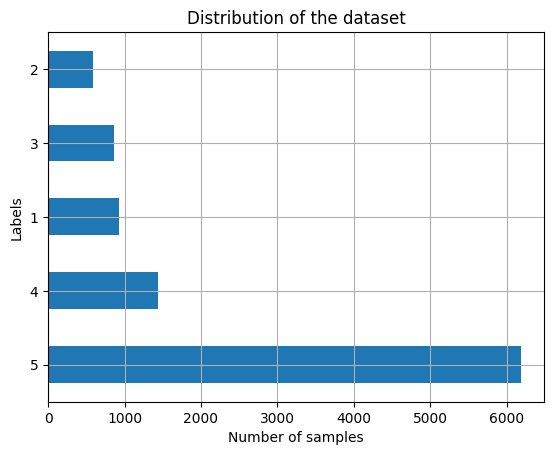

In [5]:
data['Score'].value_counts().plot(kind='barh')
plt.title("Distribution of the dataset")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.grid()
plt.show()

The data seems to heavily biased towards 5 star reviews. This might create a problem in training the network because the network will try to overfit to the 5 star rating.

#Check Word Count Distribution of Text Data

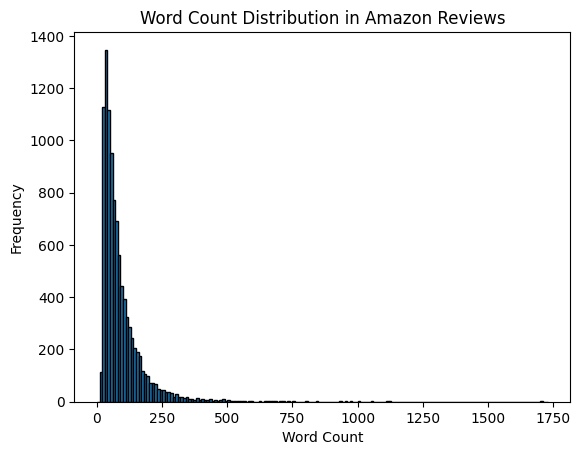

In [6]:
text_reviews = data['Text']

# Tokenize the text reviews using PyTorch's get_tokenizer
tokenizer = get_tokenizer('basic_english')
tokenized_reviews = [tokenizer(review.lower()) for review in text_reviews]

# Calculate the word count for each review
word_counts = [len(tokens) for tokens in tokenized_reviews]

# Define custom bin edges for the histogram
custom_bin_edges = range(0, max(word_counts) + 1, 10)

# Create a histogram to visualize the word count distribution
plt.hist(word_counts, bins=custom_bin_edges, edgecolor='k')
plt.title('Word Count Distribution in Amazon Reviews')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Based on the histogram of Word Count Distribution in Amazon Reviews, it is evident that people tend not to comment much (elaborate much) on their ratings, and therefore, it becomes more difficult for us to determine the star rating of a review based on textual reviews left by customers.

# Preprocessing the data by tokenizing and creating batches.

---



In [7]:
# A tokenizer allows you to parse sentences and split into words.
tokenizer = get_tokenizer("basic_english")

# Creating funciton to parse the text and tokenize it.
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


# Building a vocabulary object which contains all the text comments and can be parsed using an iterator.
# Also padding the unknwon tokens with the special <unk>. This is a special token used for words out of
# tokenizer's dictionary.
vocab = build_vocab_from_iterator(yield_tokens(x_data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


# Custom Dataset
class ReviewDataset(Dataset):

  # Converting the texts to token and then to tensors so it can be passed through the neural network.
    def __init__(self, texts, labels, vocab):
        self.texts = [
            torch.tensor(vocab(tokenizer(text)), dtype=torch.long) for text in texts
        ]
        self.labels = labels

    # Getting the length of the dataset.
    def __len__(self):
        return len(self.texts)

    # Getting the specific text and its corresponding label.
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


# Collate Function takes care of the size consistency. It makes sure every text tensor is of the same size.
# This is done by basically adding <pad>
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, padding_value=vocab["<pad>"])
    labels = torch.tensor(labels, dtype=torch.long)
    return texts_padded, labels

#Splitting data into train and test

---



In [8]:
# Using the usual test and train splitter from sklearn
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=True
)

# Creating corresponding datasets and dataloaders.
# These can be treated as collection of data stored in a convenient format for Pytorch to pass around the neural network.

train_data = ReviewDataset(x_train, y_train, vocab) # Converting the texts to tokens and then to tensors.
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn = collate_fn) # Ensuring size consistency and preparing batches.
test_data = ReviewDataset(x_test, y_test, vocab)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, collate_fn = collate_fn)

# Initializing basic parameters for the neural network

---



In [9]:
num_classes = 5 # The output labels.
hidden_size = 100 # The output size of the first hidden layer
hidden_size2 = 50 # The output size of the second hidden layer IF USED !!
vocab_size = len(vocab) # The input size of the embedding layer which is basically the length of the vocab object.

#Creating neural network class

---



In [10]:
class neural(nn.Module):
    def __init__(self, num_class):

      # The super() function ensures proper initialization of the inherited properties and methods from the parent class.
        super(neural, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # Setting the gradient to be true because the weights need to be optimized.
        self.embedding.weight.requires_grad = True

        # A fully-connected linear layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

        # Initializing demo weights
        self.init_weights()

    def init_weights(self):

        # initialize weights for neural layers
        initrange = 0.05 # chosen randomly.
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_() # Setting the initial bias to 0.

    def forward(self, x):
        # forward input x into embedding layer
        x = self.embedding(x)

        # average the output of embedding layer and forward it to linear fc layer
        x = torch.mean(x, 1)

        # Passing through the 1st linear layer.
        x = self.fc(x)
        return x

#Initiate the model, optimizer, and loss function

---



In [11]:
model = neural(num_classes).to(device) # Creating an object of the neural network model
loss_function = nn.CrossEntropyLoss().to(device) # Initializing a loss function which will allow for optimization.
optimizer = torch.optim.SGD(model.parameters(), lr = .5) # Stochastic gradient descent optimizer used to optimize the weights and biases.

# lr is called the learning rate. This is a hyper-parameter of the neural network and can be tuned to determine the best accuracy.

#Defining a training and validation funciton

---



In [12]:
# The train function runs through the train dataset and optimizes the weights.

def train_func(model, train_loader, optimizer, loss_function):

    # Initializing variables.
    train_loss = 0
    train_acc = 0
    num_examples = 0
    model.train()

    # for each batch in train data loader
    for idx, batch in enumerate(train_loader):

      #Parse the batch and extract the tensor for text and corresponding label.
        input_text, labels = batch[0], batch[1]

        # Taking transpose of the tensor to solve a size mismatch problem which arose while training the model.
        input_text = input_text.t()

        # clear optimizer gradient
        optimizer.zero_grad()

        # forward input_text through model
        output = model(input_text)

        # compute loss
        # backpropagate loss
        loss = loss_function(output, labels)
        loss.backward()

        optimizer.step()

        # Compute total loss and accuracy
        train_loss += loss.item()
        train_acc += (output.argmax(1) == labels).sum().item()
        num_examples += labels.size(0)

    return train_loss / num_examples, train_acc / num_examples


# Funciton to evaluate loss
def eval_func(data_loader, test_mode = False):

  # Again initializing variables
    eval_loss = 0
    eval_acc = 0
    num_examples = 0
    predictions = []
    model.eval()
    for batch in data_loader:
        input_text, labels = batch[0], batch[1]

        # Again transpose is taken for the text tensor to solve the size mismatch problems that arose while writing the code.
        input_text = input_text.t()

        # As we are not doing training, we don't need to keep track of gradients
        with torch.no_grad():
            output = model(input_text)

            # Similar to train function, calculating the loss and accuracy.
            if not test_mode:
                loss = loss_function(output, labels)
                eval_loss += loss.item()
                eval_acc += (output.argmax(1) == labels).sum().item()
                num_examples += labels.size(0)
            else:
                predictions.extend(output.argmax(1).tolist())

    # For testing the model in real time.
    if test_mode:
        return predictions
    return eval_loss / num_examples, eval_acc / num_examples

#Training and testing the model!

---



In [14]:
best_val_acc = 0
# Define the number of epochs which is a hyper parameter and is tuned by inspection.
num_epochs = 50

# Create a tqdm wrapper for the range of epochs
start_time = time.time()
for epoch in tqdm(range(num_epochs), desc="Training Progress", unit="epoch"):


    # train model on train_loader
    train_loss, train_acc = train_func(model, train_loader, optimizer, loss_function)

    # Evaluate the performance on validation dataset
    valid_loss, valid_acc = eval_func(test_loader)

    # If current validation_acc is better than best_val_acc,
    # update best_val_acc and save model
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        torch.save(model.state_dict(), "./saved_model")

    # Calculate the time taken for the epoch
    secs = int(time.time() - start_time)
    mins = secs // 60
    secs = secs % 60

    # Print out the loss and accuracy for this epoch
    print("Epoch: %d" % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
    print(f"\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)")
    print(f"\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)")

# Load the best model after training
model.load_state_dict(torch.load("./saved_model"))

Training Progress:   2%|▏         | 1/50 [00:02<01:46,  2.17s/epoch]

Epoch: 1  | time in 0 minutes, 2 seconds
	Loss: 0.0350(train)	|	Acc: 62.5%(train)
	Loss: 0.0351(valid)	|	Acc: 61.5%(valid)


Training Progress:   4%|▍         | 2/50 [00:04<01:37,  2.04s/epoch]

Epoch: 2  | time in 0 minutes, 4 seconds
	Loss: 0.0347(train)	|	Acc: 62.3%(train)
	Loss: 0.0351(valid)	|	Acc: 61.2%(valid)


Training Progress:   6%|▌         | 3/50 [00:06<01:33,  1.99s/epoch]

Epoch: 3  | time in 0 minutes, 6 seconds
	Loss: 0.0349(train)	|	Acc: 62.4%(train)
	Loss: 0.0352(valid)	|	Acc: 61.1%(valid)


Training Progress:   8%|▊         | 4/50 [00:07<01:30,  1.96s/epoch]

Epoch: 4  | time in 0 minutes, 7 seconds
	Loss: 0.0348(train)	|	Acc: 62.2%(train)
	Loss: 0.0382(valid)	|	Acc: 61.0%(valid)


Training Progress:  10%|█         | 5/50 [00:09<01:27,  1.95s/epoch]

Epoch: 5  | time in 0 minutes, 9 seconds
	Loss: 0.0348(train)	|	Acc: 62.3%(train)
	Loss: 0.0354(valid)	|	Acc: 61.0%(valid)


Training Progress:  12%|█▏        | 6/50 [00:12<01:28,  2.01s/epoch]

Epoch: 6  | time in 0 minutes, 12 seconds
	Loss: 0.0346(train)	|	Acc: 62.4%(train)
	Loss: 0.0357(valid)	|	Acc: 61.4%(valid)


Training Progress:  14%|█▍        | 7/50 [00:14<01:32,  2.15s/epoch]

Epoch: 7  | time in 0 minutes, 14 seconds
	Loss: 0.0347(train)	|	Acc: 62.4%(train)
	Loss: 0.0348(valid)	|	Acc: 61.3%(valid)


Training Progress:  16%|█▌        | 8/50 [00:16<01:33,  2.22s/epoch]

Epoch: 8  | time in 0 minutes, 16 seconds
	Loss: 0.0347(train)	|	Acc: 62.4%(train)
	Loss: 0.0355(valid)	|	Acc: 61.4%(valid)


Training Progress:  18%|█▊        | 9/50 [00:18<01:27,  2.13s/epoch]

Epoch: 9  | time in 0 minutes, 18 seconds
	Loss: 0.0346(train)	|	Acc: 62.4%(train)
	Loss: 0.0360(valid)	|	Acc: 61.1%(valid)


Training Progress:  20%|██        | 10/50 [00:20<01:22,  2.06s/epoch]

Epoch: 10  | time in 0 minutes, 20 seconds
	Loss: 0.0344(train)	|	Acc: 62.6%(train)
	Loss: 0.0384(valid)	|	Acc: 61.2%(valid)


Training Progress:  22%|██▏       | 11/50 [00:22<01:19,  2.03s/epoch]

Epoch: 11  | time in 0 minutes, 22 seconds
	Loss: 0.0347(train)	|	Acc: 62.4%(train)
	Loss: 0.0344(valid)	|	Acc: 61.4%(valid)


Training Progress:  24%|██▍       | 12/50 [00:24<01:16,  2.01s/epoch]

Epoch: 12  | time in 0 minutes, 24 seconds
	Loss: 0.0346(train)	|	Acc: 62.5%(train)
	Loss: 0.0349(valid)	|	Acc: 61.5%(valid)


Training Progress:  26%|██▌       | 13/50 [00:26<01:15,  2.04s/epoch]

Epoch: 13  | time in 0 minutes, 26 seconds
	Loss: 0.0346(train)	|	Acc: 62.6%(train)
	Loss: 0.0348(valid)	|	Acc: 61.3%(valid)


Training Progress:  28%|██▊       | 14/50 [00:29<01:17,  2.16s/epoch]

Epoch: 14  | time in 0 minutes, 29 seconds
	Loss: 0.0346(train)	|	Acc: 62.4%(train)
	Loss: 0.0345(valid)	|	Acc: 61.4%(valid)


Training Progress:  30%|███       | 15/50 [00:31<01:19,  2.27s/epoch]

Epoch: 15  | time in 0 minutes, 31 seconds
	Loss: 0.0348(train)	|	Acc: 62.4%(train)
	Loss: 0.0347(valid)	|	Acc: 61.5%(valid)


Training Progress:  32%|███▏      | 16/50 [00:33<01:13,  2.17s/epoch]

Epoch: 16  | time in 0 minutes, 33 seconds
	Loss: 0.0346(train)	|	Acc: 62.5%(train)
	Loss: 0.0346(valid)	|	Acc: 61.3%(valid)


Training Progress:  34%|███▍      | 17/50 [00:35<01:08,  2.09s/epoch]

Epoch: 17  | time in 0 minutes, 35 seconds
	Loss: 0.0345(train)	|	Acc: 62.2%(train)
	Loss: 0.0344(valid)	|	Acc: 61.4%(valid)


Training Progress:  36%|███▌      | 18/50 [00:37<01:04,  2.01s/epoch]

Epoch: 18  | time in 0 minutes, 37 seconds
	Loss: 0.0345(train)	|	Acc: 62.5%(train)
	Loss: 0.0362(valid)	|	Acc: 61.1%(valid)


Training Progress:  38%|███▊      | 19/50 [00:39<01:01,  1.99s/epoch]

Epoch: 19  | time in 0 minutes, 39 seconds
	Loss: 0.0345(train)	|	Acc: 62.5%(train)
	Loss: 0.0348(valid)	|	Acc: 61.6%(valid)


Training Progress:  40%|████      | 20/50 [00:41<00:59,  1.99s/epoch]

Epoch: 20  | time in 0 minutes, 41 seconds
	Loss: 0.0344(train)	|	Acc: 62.4%(train)
	Loss: 0.0359(valid)	|	Acc: 61.1%(valid)


Training Progress:  42%|████▏     | 21/50 [00:43<01:01,  2.11s/epoch]

Epoch: 21  | time in 0 minutes, 43 seconds
	Loss: 0.0344(train)	|	Acc: 62.5%(train)
	Loss: 0.0351(valid)	|	Acc: 61.5%(valid)


Training Progress:  44%|████▍     | 22/50 [00:46<01:01,  2.21s/epoch]

Epoch: 22  | time in 0 minutes, 46 seconds
	Loss: 0.0343(train)	|	Acc: 62.5%(train)
	Loss: 0.0348(valid)	|	Acc: 61.7%(valid)


Training Progress:  46%|████▌     | 23/50 [00:48<00:59,  2.19s/epoch]

Epoch: 23  | time in 0 minutes, 48 seconds
	Loss: 0.0346(train)	|	Acc: 62.0%(train)
	Loss: 0.0348(valid)	|	Acc: 61.5%(valid)


Training Progress:  48%|████▊     | 24/50 [00:50<00:55,  2.12s/epoch]

Epoch: 24  | time in 0 minutes, 50 seconds
	Loss: 0.0345(train)	|	Acc: 62.6%(train)
	Loss: 0.0353(valid)	|	Acc: 61.4%(valid)


Training Progress:  50%|█████     | 25/50 [00:52<00:52,  2.09s/epoch]

Epoch: 25  | time in 0 minutes, 52 seconds
	Loss: 0.0342(train)	|	Acc: 62.6%(train)
	Loss: 0.0353(valid)	|	Acc: 61.1%(valid)


Training Progress:  52%|█████▏    | 26/50 [00:54<00:49,  2.06s/epoch]

Epoch: 26  | time in 0 minutes, 54 seconds
	Loss: 0.0342(train)	|	Acc: 62.5%(train)
	Loss: 0.0381(valid)	|	Acc: 61.4%(valid)


Training Progress:  54%|█████▍    | 27/50 [00:56<00:46,  2.02s/epoch]

Epoch: 27  | time in 0 minutes, 56 seconds
	Loss: 0.0342(train)	|	Acc: 62.5%(train)
	Loss: 0.0343(valid)	|	Acc: 61.0%(valid)


Training Progress:  56%|█████▌    | 28/50 [00:58<00:46,  2.12s/epoch]

Epoch: 28  | time in 0 minutes, 58 seconds
	Loss: 0.0344(train)	|	Acc: 62.7%(train)
	Loss: 0.0358(valid)	|	Acc: 61.0%(valid)


Training Progress:  58%|█████▊    | 29/50 [01:00<00:46,  2.23s/epoch]

Epoch: 29  | time in 1 minutes, 0 seconds
	Loss: 0.0346(train)	|	Acc: 62.2%(train)
	Loss: 0.0345(valid)	|	Acc: 61.5%(valid)


Training Progress:  60%|██████    | 30/50 [01:03<00:43,  2.18s/epoch]

Epoch: 30  | time in 1 minutes, 3 seconds
	Loss: 0.0342(train)	|	Acc: 62.9%(train)
	Loss: 0.0351(valid)	|	Acc: 61.4%(valid)


Training Progress:  62%|██████▏   | 31/50 [01:05<00:40,  2.12s/epoch]

Epoch: 31  | time in 1 minutes, 5 seconds
	Loss: 0.0341(train)	|	Acc: 62.7%(train)
	Loss: 0.0351(valid)	|	Acc: 61.7%(valid)


Training Progress:  64%|██████▍   | 32/50 [01:06<00:37,  2.07s/epoch]

Epoch: 32  | time in 1 minutes, 6 seconds
	Loss: 0.0344(train)	|	Acc: 62.9%(train)
	Loss: 0.0351(valid)	|	Acc: 61.2%(valid)


Training Progress:  66%|██████▌   | 33/50 [01:08<00:34,  2.04s/epoch]

Epoch: 33  | time in 1 minutes, 8 seconds
	Loss: 0.0345(train)	|	Acc: 62.2%(train)
	Loss: 0.0340(valid)	|	Acc: 61.8%(valid)


Training Progress:  68%|██████▊   | 34/50 [01:10<00:32,  2.03s/epoch]

Epoch: 34  | time in 1 minutes, 10 seconds
	Loss: 0.0342(train)	|	Acc: 62.8%(train)
	Loss: 0.0362(valid)	|	Acc: 61.3%(valid)


Training Progress:  70%|███████   | 35/50 [01:13<00:31,  2.10s/epoch]

Epoch: 35  | time in 1 minutes, 13 seconds
	Loss: 0.0342(train)	|	Acc: 62.3%(train)
	Loss: 0.0405(valid)	|	Acc: 61.1%(valid)


Training Progress:  72%|███████▏  | 36/50 [01:15<00:31,  2.23s/epoch]

Epoch: 36  | time in 1 minutes, 15 seconds
	Loss: 0.0341(train)	|	Acc: 62.6%(train)
	Loss: 0.0344(valid)	|	Acc: 61.5%(valid)


Training Progress:  74%|███████▍  | 37/50 [01:18<00:29,  2.28s/epoch]

Epoch: 37  | time in 1 minutes, 18 seconds
	Loss: 0.0341(train)	|	Acc: 62.7%(train)
	Loss: 0.0348(valid)	|	Acc: 62.3%(valid)


Training Progress:  76%|███████▌  | 38/50 [01:20<00:25,  2.17s/epoch]

Epoch: 38  | time in 1 minutes, 20 seconds
	Loss: 0.0342(train)	|	Acc: 62.8%(train)
	Loss: 0.0352(valid)	|	Acc: 61.9%(valid)


Training Progress:  78%|███████▊  | 39/50 [01:21<00:22,  2.07s/epoch]

Epoch: 39  | time in 1 minutes, 21 seconds
	Loss: 0.0340(train)	|	Acc: 62.5%(train)
	Loss: 0.0342(valid)	|	Acc: 61.7%(valid)


Training Progress:  80%|████████  | 40/50 [01:23<00:20,  2.02s/epoch]

Epoch: 40  | time in 1 minutes, 23 seconds
	Loss: 0.0342(train)	|	Acc: 62.6%(train)
	Loss: 0.0347(valid)	|	Acc: 61.5%(valid)


Training Progress:  82%|████████▏ | 41/50 [01:25<00:17,  1.99s/epoch]

Epoch: 41  | time in 1 minutes, 25 seconds
	Loss: 0.0342(train)	|	Acc: 62.8%(train)
	Loss: 0.0383(valid)	|	Acc: 63.2%(valid)


Training Progress:  84%|████████▍ | 42/50 [01:28<00:18,  2.32s/epoch]

Epoch: 42  | time in 1 minutes, 28 seconds
	Loss: 0.0345(train)	|	Acc: 62.4%(train)
	Loss: 0.0342(valid)	|	Acc: 62.0%(valid)


Training Progress:  86%|████████▌ | 43/50 [01:32<00:18,  2.64s/epoch]

Epoch: 43  | time in 1 minutes, 32 seconds
	Loss: 0.0342(train)	|	Acc: 62.7%(train)
	Loss: 0.0358(valid)	|	Acc: 61.0%(valid)


Training Progress:  88%|████████▊ | 44/50 [01:34<00:14,  2.43s/epoch]

Epoch: 44  | time in 1 minutes, 34 seconds
	Loss: 0.0340(train)	|	Acc: 62.5%(train)
	Loss: 0.0349(valid)	|	Acc: 61.1%(valid)


Training Progress:  90%|█████████ | 45/50 [01:36<00:11,  2.29s/epoch]

Epoch: 45  | time in 1 minutes, 36 seconds
	Loss: 0.0339(train)	|	Acc: 62.6%(train)
	Loss: 0.0346(valid)	|	Acc: 61.7%(valid)


Training Progress:  92%|█████████▏| 46/50 [01:37<00:08,  2.16s/epoch]

Epoch: 46  | time in 1 minutes, 37 seconds
	Loss: 0.0341(train)	|	Acc: 62.7%(train)
	Loss: 0.0351(valid)	|	Acc: 61.3%(valid)


Training Progress:  94%|█████████▍| 47/50 [01:39<00:06,  2.07s/epoch]

Epoch: 47  | time in 1 minutes, 39 seconds
	Loss: 0.0341(train)	|	Acc: 62.5%(train)
	Loss: 0.0347(valid)	|	Acc: 61.5%(valid)


Training Progress:  96%|█████████▌| 48/50 [01:41<00:04,  2.04s/epoch]

Epoch: 48  | time in 1 minutes, 41 seconds
	Loss: 0.0340(train)	|	Acc: 62.8%(train)
	Loss: 0.0359(valid)	|	Acc: 61.7%(valid)


Training Progress:  98%|█████████▊| 49/50 [01:43<00:02,  2.09s/epoch]

Epoch: 49  | time in 1 minutes, 44 seconds
	Loss: 0.0342(train)	|	Acc: 62.8%(train)
	Loss: 0.0351(valid)	|	Acc: 61.6%(valid)


Training Progress: 100%|██████████| 50/50 [01:46<00:00,  2.13s/epoch]

Epoch: 50  | time in 1 minutes, 46 seconds
	Loss: 0.0339(train)	|	Acc: 62.7%(train)
	Loss: 0.0357(valid)	|	Acc: 61.1%(valid)


<All keys matched successfully>

#Final Conclusions.


---



As seen, the accuracy seems to be capping off at **66%.** It is also determined that deeper neural nets (adding another linear layer) decreases the accuracy by a lot. This can be tried by adding the layer in neural class using the specified hidden sizes. Fixes to this problem require implementing a better architecture and improving the layers. For example:


1.   For our current network, the embedding layer is being implemented from scratch. This could be replaced by pre-trained word vectors such as word2vec from Google. This will increase the accuracy by a lot because the network doesn't have to learn the embeddings and weights at the same time.
2.   Implementing transformers or convolution neural networks can vastly change the accuracy because of their streamlined architecture. CNNs are naturally suited for capturing features that are translationally invariant. In text, this can be beneficial for identifying similar patterns or features regardless of their position in the sentence.
3. Better pre-processing for the text such as removing stop words, punctuation, converting tokens to their lemmas might also help with the model by making the input text easier to understand make patterns out of.
